In [6]:
import random
from timeit import timeit

from tqdm import tqdm
from memory_profiler import memory_usage
import numpy as np
from scipy.stats import poisson

import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from loss import phase_insensitive_loss_cvx
from gd_opt import learn_phase_insensitive_povm
from quantum import pnr_povm, diag_povm_fidelity, photodetector_povm
from tune import objective
from utils import check_diag_povm
from custom_types import Hyperparameters

In [7]:
N = 25  # number of POVM outcomes
D = 512  # D is number of probes

### Time complexity

In [8]:
Ms = range(1000, 1050, 50)
device = 'cuda'
number = 5
time_gd = []
time_mosek = []


for M in tqdm(Ms, desc="Performing time measurements"):
    # PNR detector POVM
    eta = random.uniform(0.1, 0.9)
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=0.9)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = M/1.75
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 

    targets = probes @ true_povm  
    lam_smoothing = 1e-5
    hyperparams = Hyperparameters(lr=0.1, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=50, batch_size=32)

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    t = timeit(lambda: learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False), number=number)
    time_gd.append(t / number) 

    t = timeit(lambda: phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK"), number=number) 
    time_mosek.append(t / number)

Performing time measurements: 100%|██████████| 1/1 [08:11<00:00, 491.48s/it]


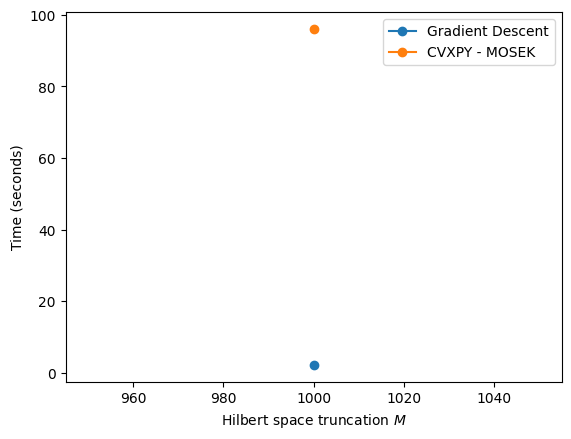

In [9]:
plt.plot(Ms, time_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, time_mosek, label="CVXPY - MOSEK", marker="o")
plt.xlabel(r"Hilbert space truncation $M$ ")
plt.ylabel("Time (seconds)")
# plt.yscale("log")
plt.legend();

### Memory complexity

In [10]:
Ms = range(50, 200, 50)
device = 'cuda'
mem_usage_gd = []
mem_usage_mosek = []
mem_usage_scs = []

for M in Ms:
    # PNR detector POVM
    eta = random.uniform(0.1, 0.9)
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=0.9)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = M/1.75
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 

    targets = probes @ true_povm  
    lam_smoothing = 1e-5
    hyperparams = Hyperparameters(lr=0.1, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=50, batch_size=32)

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    mem = memory_usage( (learn_phase_insensitive_povm, (logits, hyperparams, dataset, lam_smoothing)) )
    mem_usage_gd.append(max(mem) / 1000)  # divide by 1k to go from Mb to Gb

    mem = memory_usage( (phase_insensitive_loss_cvx, (targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")) ) 
    mem_usage_mosek.append(max(mem) / 1000)


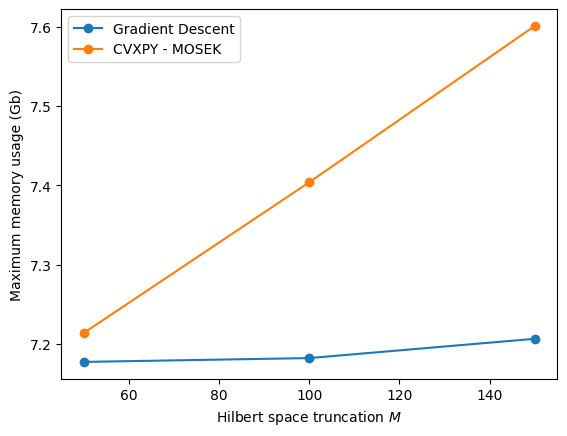

In [11]:
plt.plot(Ms, mem_usage_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, mem_usage_mosek, label="CVXPY - MOSEK", marker="o")
plt.xlabel(r"Hilbert space truncation $M$ ")
plt.ylabel("Maximum memory usage (Gb)")
# plt.yscale("log")
plt.legend();